In [50]:
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

import pandas as pd
import uproot
import glob
import tqdm

df = pd.DataFrame()
directory = "/eos/purdue/store/data/Run2016B/SingleMuon/NANOAOD/02Apr2020_ver2-v1/20000/"

for filename in tqdm.tqdm(glob.glob(directory+"*.root")):
    fn = filename.split("/")[-1].replace(".root", "")
    tree = uproot.open(filename)["Events"]
    for column in tree.keys():
        row = {
            "file": fn,
            "collection": column.split("_")[0],
            "branch": "_".join(column.split("_")[1:]),
            "column": column,
            "compressed_bytes": tree[column].compressed_bytes,
            "uncompressed_bytes": tree[column].uncompressed_bytes,
            "num_entries": tree.num_entries
        }
        df = pd.concat([df, pd.DataFrame([row])])

df["compressed_bytes_per_event"] = df.compressed_bytes/df.num_entries
df["uncompressed_bytes_per_event"] = df.uncompressed_bytes/df.num_entries

100%|██████████| 72/72 [08:58<00:00,  7.48s/it]


### Print heaviest collections

In [124]:
def group_by_file(group):
    result = group.groupby('file').sum(numeric_only=True).mean()
    return result

grouped = df.groupby('collection').apply(group_by_file)
grouped["kb/evt"] = grouped["compressed_bytes_per_event"]/1024

grouped["kb/evt"].sort_values(ascending=False).head(15)

collection
Jet                0.163304
Muon               0.084234
Tau                0.071128
Electron           0.035045
CorrT1METJet       0.034419
TrigObj            0.030956
SoftActivityJet    0.029796
SV                 0.020973
MET                0.018679
Photon             0.015917
FatJet             0.015093
PuppiMET           0.014651
HLT                0.014538
L1                 0.011752
PV                 0.010116
Name: kb/evt, dtype: float64

### Plot distribution of column size for different collections

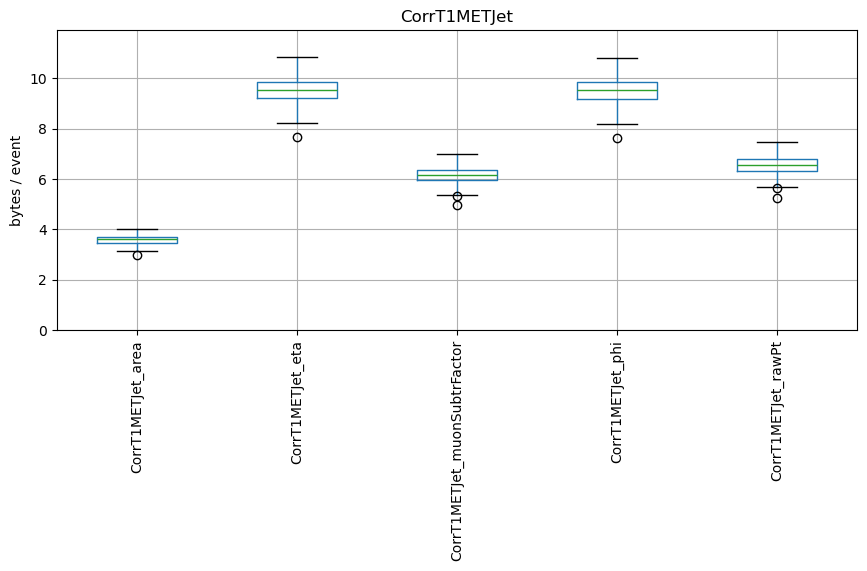

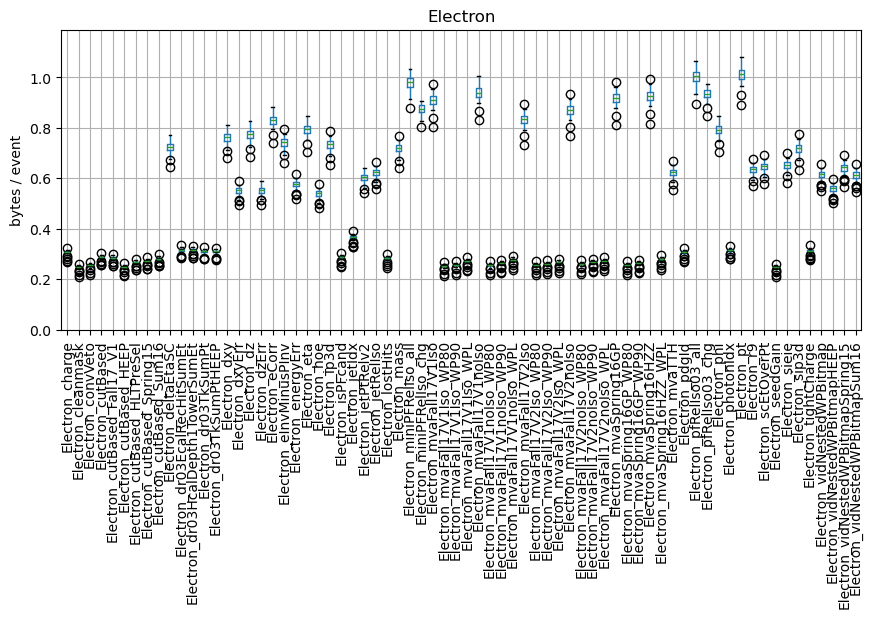

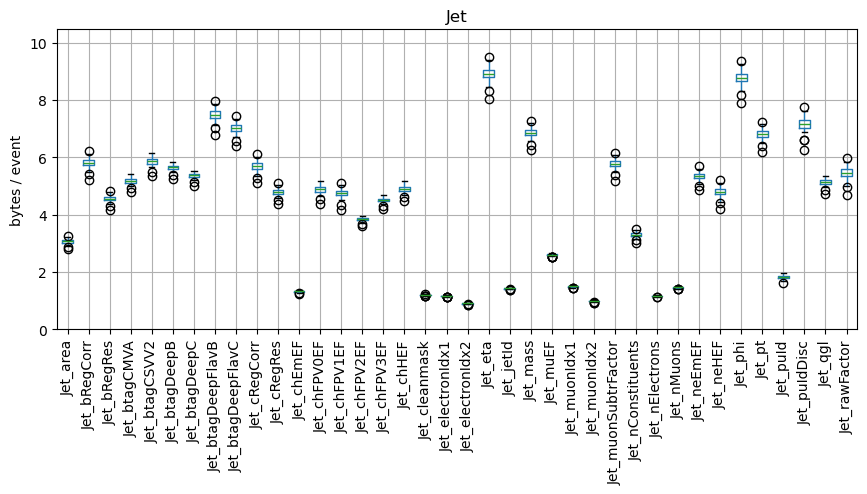

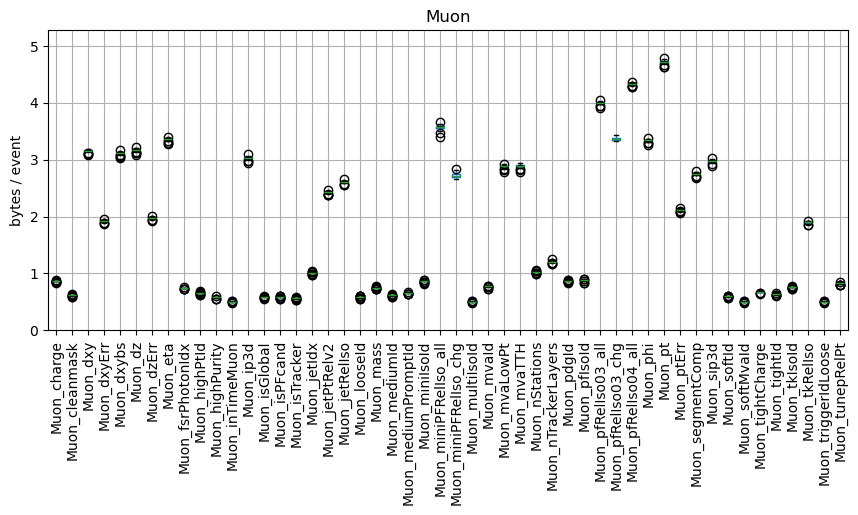

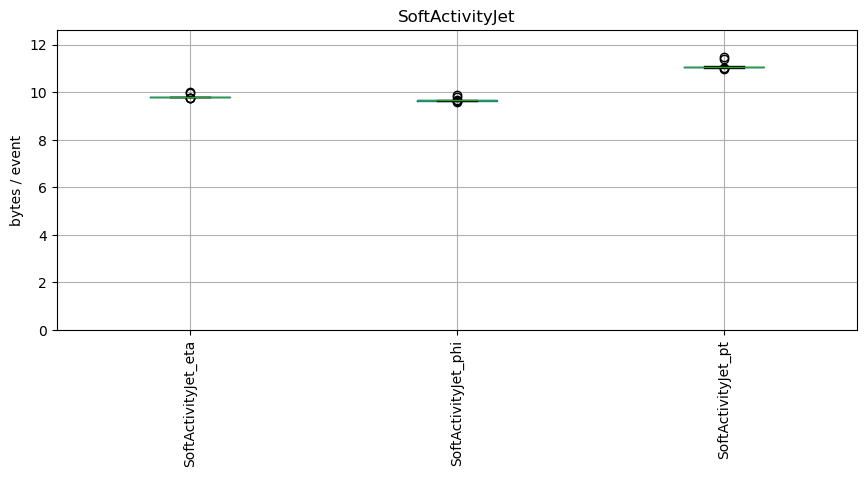

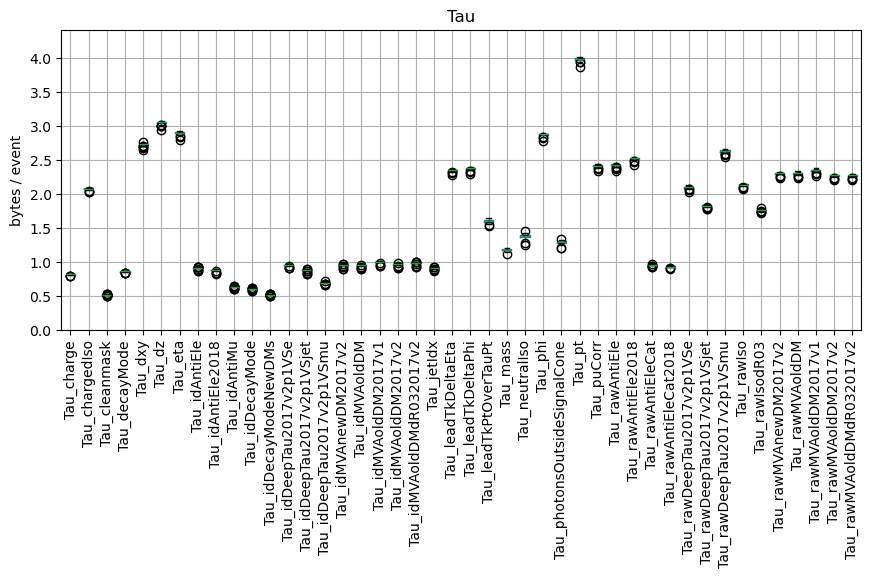

In [129]:
plot_collections = [
    "Electron", "Muon", "Tau", "Jet",
    # "FatJet", "MET", "IsoTrack", "PuppiMET",
    # "SubJet", "TrigObj", 
    "SoftActivityJet", "CorrT1METJet"
]

for collection in df.collection.unique():
    if collection not in plot_collections:
        continue
    ax = df[df.collection==collection].boxplot(
        by='column',
        column='compressed_bytes_per_event',
        rot=90,
        figsize=(10,4)
    )
    ax.set_xlabel('')
    ax.set_ylabel('bytes / event')
    plt.title(collection)
    plt.suptitle('')
    plt.ylim(0,df.loc[df.collection==collection, "compressed_bytes_per_event"].max()*1.1)


### Plot distributions of (un)compressed column size for all columns

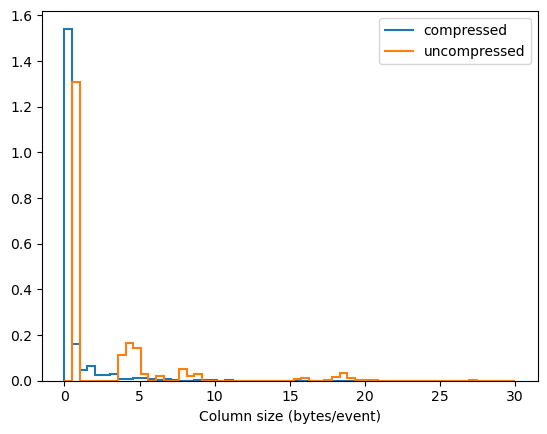

In [132]:
bins = np.linspace(0, 30, 60)
hep.histplot(
    np.histogram(df.compressed_bytes_per_event, bins),
    label="compressed",
    density=True
)
hep.histplot(
    np.histogram(df.uncompressed_bytes_per_event, bins),
    label="uncompressed",
    density=True
)

plt.xlabel('Column size (bytes/event)')
plt.legend()

plt.show()